In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
import sys
sys.path.append('..')
from grav_waves import *

In [3]:
FONTSIZE = 25
FIGSIZE = 10

In [4]:
# Cost file information
#event_name = 'GW170817'
#event_name = 'GW200115_042309'
event_name = 'GW190425'
ifo = 'L1'
cds = 'theta1eta'
Ns = 2 * [256]

In [5]:
cost_file = f'../cost_values/cost_values__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}.h5'
cost_file_signalonly = f'../cost_values/cost_values__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}__signalonly.h5'
cost_file_noiseonly = f'../cost_values/cost_values__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}__noiseonly.h5'

In [6]:
# Information required to generate new cost file
input_path_strain = f'txt_data/{event_name}_strain_{ifo}.txt'
input_path_strain_signalonly = f'txt_data/{event_name}_strain_{ifo}_signalonly.txt'
input_path_strain_noiseonly = f'txt_data/{event_name}_strain_{ifo}_noiseonly.txt'
input_path_psd = f'txt_data/{event_name}_psd_{ifo}.txt'

# For event GW170817
#m1_signal = 1.3758 # Msol
#m2_signal = 1.3758 # Msol
#tc_signal = 170.710205078125 # seconds
#min_mass = [1,1] # Msol
#max_mass = [5,5] # Msol

# For event GW200115_042309
#m1_signal = 7.58110 # Msol
#m2_signal = 1.32952 # Msol
#tc_signal = 166.696533203125 # seconds
#min_mass = [5,1] # Msol
#max_mass = [9,5] # Msol

# For event GW190425
m1_signal = 1.8913 # Msol
m2_signal = 1.5449 # Msol
tc_signal = 166.683837890625 # seconds
min_mass = [1,1] # Msol
max_mass = [5,5] # Msol

In [7]:
if not (os.path.exists(input_path_strain_signalonly) and os.path.exists(input_path_strain_noiseonly)):
    print('Generating signal-only and noise-only strain data.')
    
    f_strain = np.loadtxt(input_path_strain)
    time = f_strain[0,:]
    strain = f_strain[1,:]
    
    N_time = len(strain)
    fs = 1/(time[1]-time[0])
    df = fs/N_time
    
    strain_dft = np.fft.fft(strain) / fs
    freqs_dft = np.fft.fftfreq(N_time, 1/fs)

    # Truncate frequencies
    fL = 20
    kL = int( max(1, np.ceil(N_time*fL/fs)) )

    v_lso = 1/np.sqrt(6)
    M_max = 12
    f_lso = v_lso**3 / (np.pi * M_max * MSOL_TO_SEC)
    kH = int( min(np.floor((N_time-1)/2), np.floor(N_time*f_lso/fs)) )

    freqs = freqs_dft[kL:kH+1]
    data_series = {'waveform': strain_dft[kL:kH+1], 'freqs': freqs, 'df': df}

    f_psd = np.loadtxt(input_path_psd)
    freqs_psd = f_psd[0,:]
    psd = f_psd[1,:]

    if not np.array_equal(freqs, freqs_psd[kL:kH+1]):
        raise Exception('Signal and noise frequencies do not match')

    noise_psd = {'waveform': psd[kL:kH+1], 'freqs': freqs, 'df': df}
    
    M_signal, eta_signal = m1m2_to_Meta(m1_signal, m2_signal)
    h_signal = template_taylorf2(freqs, M_signal, eta_signal, tc_signal)
    h_signal['waveform'] = h_signal['waveform'] / np.sqrt( abs(template_overlap(h_signal, h_signal, noise_psd)) )
    
    strain_signalonly_dft = np.zeros(kL)
    strain_signalonly_dft = np.append(strain_signalonly_dft, template_overlap(h_signal, data_series, noise_psd) * h_signal['waveform'])
    strain_signalonly_dft = np.append(strain_signalonly_dft, np.zeros(N_time-kH-1))
    strain_signalonly = 2 * np.real( np.fft.ifft(strain_signalonly_dft) * fs )
    np.savetxt(input_path_strain_signalonly, (time, strain_signalonly))
    
    strain_noiseonly_dft = np.zeros(kL)
    strain_noiseonly_dft = np.append(strain_noiseonly_dft, data_series['waveform'] - template_overlap(h_signal, data_series, noise_psd) * h_signal['waveform'])
    strain_noiseonly_dft = np.append(strain_noiseonly_dft, np.zeros(N_time-kH-1))
    strain_noiseonly = 2 * np.real( np.fft.ifft(strain_noiseonly_dft) * fs )
    np.savetxt(input_path_strain_noiseonly, (time, strain_noiseonly))
    
    print('Done.')

Generating signal-only and noise-only strain data.
Done.


In [8]:
if not os.path.exists(cost_file):
    print('Cost file does not exist.')
    print('Generating cost function values...')
    write_cost_values(cost_file, input_path_strain, input_path_psd, cds, 
                      Ns, m1_signal, m2_signal, tc_signal, min_mass, max_mass)
    print('Done.')
    
if not os.path.exists(cost_file_signalonly):
    print('Cost file (signal-only) does not exist.')
    print('Generating cost function values...')
    write_cost_values(cost_file_signalonly, input_path_strain_signalonly, input_path_psd, cds, 
                      Ns, m1_signal, m2_signal, tc_signal, min_mass, max_mass)
    print('Done.')
    
if not os.path.exists(cost_file_noiseonly):
    print('Cost file (noise-only) does not exist.')
    print('Generating cost function values...')
    write_cost_values(cost_file_noiseonly, input_path_strain_noiseonly, input_path_psd, cds, 
                      Ns, m1_signal, m2_signal, tc_signal, min_mass, max_mass)
    print('Done.')

Cost file does not exist.
Generating cost function values...
Done.
Cost file (signal-only) does not exist.
Generating cost function values...
Done.
Cost file (noise-only) does not exist.
Generating cost function values...
Done.


In [9]:
if cds == 'm1m2':
    cd1_label = r'$m_1 / M_\odot$'
    cd2_label = r'$m_2 / M_\odot$'
elif cds == 'theta1eta':
    cd1_label = r'$\theta_1$'
    cd2_label = r'$\eta$'
else:
    cd1_label = 'Coordinate 1'
    cd2_label = 'Coordinate 2'

In [10]:
hf = h5py.File(cost_file, 'r')

C = hf['cost_values'][...]
cd1_grid = hf['cd1'][...]
cd2_grid = hf['cd2'][...]
cd1_signal = hf['cd1_signal'][...]
cd2_signal = hf['cd2_signal'][...]

hf.close()

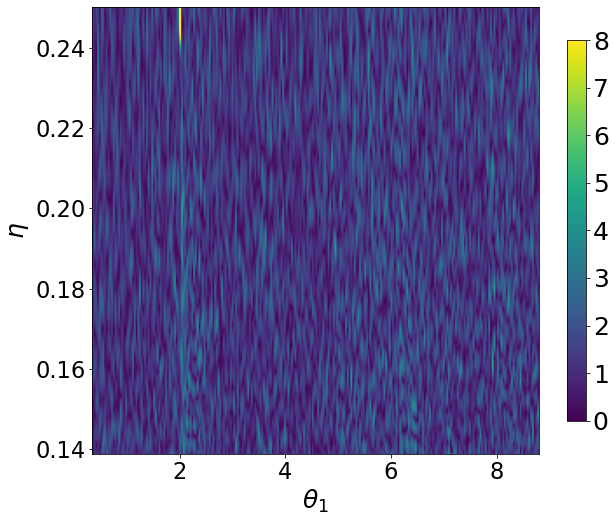

In [11]:
fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

extent = (min(cd1_grid), max(cd1_grid), min(cd2_grid), max(cd2_grid))
aspect = (max(cd1_grid) - min(cd1_grid)) / (max(cd2_grid) - min(cd2_grid))
cax = ax.imshow( np.transpose(-C.reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )

#ax.set_xticks(np.arange(5.0, 9.5, 0.5))
#ax.set_yticks(np.arange(1.0, 5.5, 0.5))
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
ax.set_xlabel(cd1_label, fontsize=FONTSIZE)
ax.set_ylabel(cd2_label, fontsize=FONTSIZE)

cbar = fig.colorbar(cax, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
cax.set_clim([0, 8])
cbar.set_ticks(np.arange(0,9,1))

#ax.plot(cd1_signal, cd2_signal, 'r.', markersize=10)

fig.savefig(f'figures/SNR__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}.pdf', format='pdf', bbox_inches='tight')

In [12]:
hf = h5py.File(cost_file_signalonly, 'r')

C_signalonly = hf['cost_values'][...]
cd1_grid_signalonly = hf['cd1'][...]
cd2_grid_signalonly = hf['cd2'][...]
cd1_signal_signalonly = hf['cd1_signal'][...]
cd2_signal_signalonly = hf['cd2_signal'][...]

hf.close()

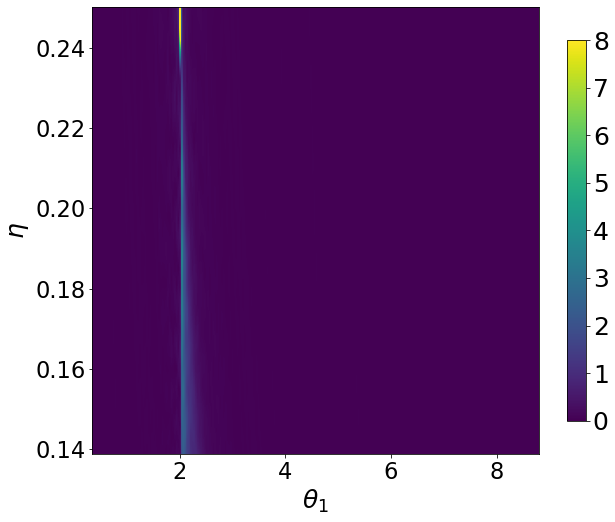

In [13]:
fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

extent = (min(cd1_grid_signalonly), max(cd1_grid_signalonly), min(cd2_grid_signalonly), max(cd2_grid_signalonly))
aspect = (max(cd1_grid_signalonly) - min(cd1_grid_signalonly)) / (max(cd2_grid_signalonly) - min(cd2_grid_signalonly))
cax = ax.imshow( np.transpose(-C_signalonly.reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )

#ax.set_xticks(np.arange(5.0, 9.5, 0.5))
#ax.set_yticks(np.arange(1.0, 5.5, 0.5))
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
ax.set_xlabel(cd1_label, fontsize=FONTSIZE)
ax.set_ylabel(cd2_label, fontsize=FONTSIZE)

cbar = fig.colorbar(cax, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
cax.set_clim([0, 8])
cbar.set_ticks(np.arange(0,9,1))

#ax.plot(cd1_signal, cd2_signal, 'r.', markersize=10)

fig.savefig(f'figures/SNR__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}_signalonly.pdf', format='pdf', bbox_inches='tight')

In [14]:
hf = h5py.File(cost_file_noiseonly, 'r')

C_noiseonly = hf['cost_values'][...]
cd1_grid_noiseonly = hf['cd1'][...]
cd2_grid_noiseonly = hf['cd2'][...]
cd1_signal_noiseonly = hf['cd1_signal'][...]
cd2_signal_noiseonly = hf['cd2_signal'][...]

hf.close()

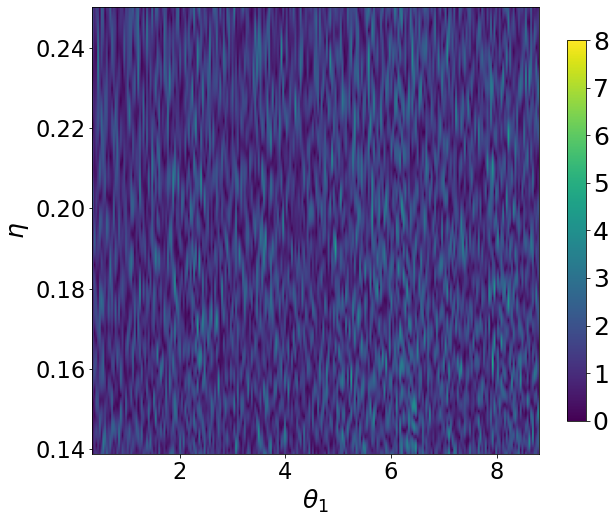

In [15]:
fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

extent = (min(cd1_grid_noiseonly), max(cd1_grid_noiseonly), min(cd2_grid_noiseonly), max(cd2_grid_noiseonly))
aspect = (max(cd1_grid_noiseonly) - min(cd1_grid_noiseonly)) / (max(cd2_grid_noiseonly) - min(cd2_grid_noiseonly))
cax = ax.imshow( np.transpose(-C_noiseonly.reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )

#ax.set_xticks(np.arange(5.0, 9.5, 0.5))
#ax.set_yticks(np.arange(1.0, 5.5, 0.5))
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
ax.set_xlabel(cd1_label, fontsize=FONTSIZE)
ax.set_ylabel(cd2_label, fontsize=FONTSIZE)
    
cbar = fig.colorbar(cax, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
cax.set_clim([0, 8])
cbar.set_ticks(np.arange(0,9,1))

#ax.plot(cd1_signal, cd2_signal, 'r.', markersize=10)

fig.savefig(f'figures/SNR__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}_noiseonly.pdf', format='pdf', bbox_inches='tight')